## **Домашнее задание №7**
## **Постановка задачи**

Хотим обучить модель, которая переводит изображения в **латентное пространство**, где  
- изображения **одного класса** (или визуально похожие) расположены **близко**,  
- изображения **разных классов** — **далеко**.

В ходе работы отвечаем на вопросы:  
- **Что такое похожесть** изображений в ML-смысле?  
- **Как обучить сеть**, чтобы получить такое пространство?  
- **Как искать** похожие картинки быстро и качественно?


## **Датасет и разметка**

- **CARS196** — ~16k изображений, **196 классов** (модели/годы авто).  
- **devkit**:
  - `cars_train_annos.mat` — имена файлов **train** и **классы**,
  - `cars_test_annos.mat` — имена файлов **test** (**без** классов),
  - `cars_meta.mat` — текстовые **названия классов**.
- Файлы изображений:
  - `cars/data/cars_train/*.jpg` — **галерея** (gallery) и источник для валидации,
  - `cars/data/cars_test/*.jpg` — **финальные запросы** без меток.
- **Валидация**: из train делаем **стратифицированный сплит 90/10**. Метрики считаем на **val** (у test меток нет).

---

## **Почему не классификация?**

- По заданию **нельзя** просто предсказывать класс.  
- Мы решаем задачу **image retrieval**: сеть выдаёт **эмбеддинг** (вектор), а похожие ищем по **расстояниям** между векторами.  
- Такой подход **универсальнее** — можно искать похожесть даже для **новых классов**, которых не было при обучении.

---

## **Архитектура модели**

- **Backbone:** **EfficientNet-B0** (вместо ResNet50).  
- **Projection head:** `Linear → BatchNorm1d` до размера эмбеддинга **512**.  
- **Нормализация эмбеддинга:** **L2** (делаем длину вектора = 1) — стабилизирует обучение, делает косинусную близость ≈ L2.

---

## **Функция потерь: Triplet Loss**

- Для якоря **a**, позитивного **p** (тот же класс) и негативного **n** (другой класс) требуем:
  - `d(a, p) + margin < d(a, n)`
- Формула:
  - **L = max(0, d(a,p) − d(a,n) + m)**
- **Hard mining:** используем **BatchHardMiner** — для каждого якоря подбирается **самый сложный** `p` и `n` внутри батча.
- Важно: в батче должно быть **несколько примеров одного класса** (самплер «**M-per-class**» или просто большой batch size).

---

## **Аугментации**

- **Train**:
  - `RandomResizedCrop(224)`
  - `RandomHorizontalFlip()`
  - `ColorJitter()`
  - `GaussianBlur()`
- **Validation/Test**:
  - `Resize(224)`
  - `Normalize(mean, std)`

Аугментации делают модель устойчивее и помогают не переобучаться.

---

## **Обучение**

- **Оптимизатор:** `AdamW(lr=3e-4, weight_decay=1e-4)`  
- **Эпох:** ~30  
- **Метрика:** `val_loss` (TripletLoss)  
- `num_workers=0` — иначе Дата лоадер падал хз как пофиксить.  

---

## **Поиск похожих изображений**

1. Прогоняем **gallery (train)** через модель → матрица эмбеддингов `G`.  
2. Прогоняем **query (val/test)** → эмбеддинги `Q`.  
3. Индексируем `G` в **FAISS** (`IndexFlatL2`).  
4. Для каждого `q ∈ Q` ищем `top-K` ближайших `g ∈ G`.  
   Это и есть список «похожих» изображений.

---

## **Метрики качества**

Считаем на **val** (у test меток нет).

- **Precision@k** — доля правильных среди `k` ближайших.  
- **Recall@k** — хотя бы одно верное совпадение среди `k` ближайших.  
- **mAP@k** — усреднённая точность по рангу (mean Average Precision).

Пример полученных результатов:
P@1 ≈ 0.51
R@1 ≈ 0.51
mAP@10 ≈ 0.55

## **Теория по проще**

- **Metric Learning** — обучение представлений, где расстояние отражает похожесть.  
- **Эмбеддинг** — вектор признаков (у нас размер 512).  
- **Triplet Loss** — стремится сделать якорь ближе к позитиву, чем к негативу.  
- **Hard Mining** — выбирает сложные примеры для более эффективного обучения.  
- **FAISS** — библиотека быстрого поиска ближайших соседей.  
- **Grad-CAM** — визуализирует, какие области изображения наиболее важны для модели.

---

## **пайплайн**

1. Загрузить данные (`cars_train`, `devkit`).  
2. Сформировать `fname → class`, разделить на train/val.  
3. Создать `Dataset` с аугментациями.  
4. Обучить модель (`EfficientNet-B0 + TripletLoss`).  
5. Получить эмбеддинги, построить FAISS-индекс.  
6. Посчитать метрики (**P@k**, **R@k**, **mAP@k**).  
7. Визуализировать Grad-CAM для правильных и ошибочных примеров.  
8. (Опционально) Сгенерировать CSV с top-5 соседями для теста.


In [1]:
!pip install pytorch_metric_learning
!pip install faiss-cpu

  Using cached pytorch_metric_learning-2.9.0-py3-none-any.whl.metadata (18 kB)
Using cached pytorch_metric_learning-2.9.0-py3-none-any.whl (127 kB)


In [2]:
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
device = 'cuda' 

In [4]:
# !pip -q install gdown
import zipfile, shutil, gdown
from pathlib import Path

CARS_DIR = Path("cars")          
META_DIR = CARS_DIR / "meta"
META_DIR.mkdir(parents=True, exist_ok=True)

DEVKIT_ID  = "1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7"  
DEVKIT_ZIP = META_DIR / "devkit.zip"

def gdown_id(file_id: str, out_path: Path):
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, str(out_path), quiet=False)

print("Скачиваю devkit.zip в HW7/cars/meta ...")
gdown_id(DEVKIT_ID, DEVKIT_ZIP)

print("Распаковываю devkit.zip ...")
with zipfile.ZipFile(DEVKIT_ZIP, 'r') as zf:
    zf.extractall(META_DIR)

inner = META_DIR / "devkit"
if inner.exists() and inner.is_dir():
    for p in inner.iterdir():
        shutil.move(str(p), str(META_DIR / p.name))
    shutil.rmtree(inner)

print("Содержимое HW7/cars/meta:", [p.name for p in META_DIR.iterdir()])


Скачиваю devkit.zip в HW7/cars/meta ...


Downloading...
From: https://drive.google.com/uc?id=1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7
To: g:\ml\2sem\NN_VK\task7\cars\meta\devkit.zip
100%|██████████| 332k/332k [00:00<00:00, 99.3MB/s]


Распаковываю devkit.zip ...
Содержимое HW7/cars/meta: ['cars_meta.mat', 'cars_test_annos.mat', 'cars_train_annos.mat', 'devkit.zip', 'eval_train.m', 'README.txt', 'train_perfect_preds.txt', '__MACOSX']


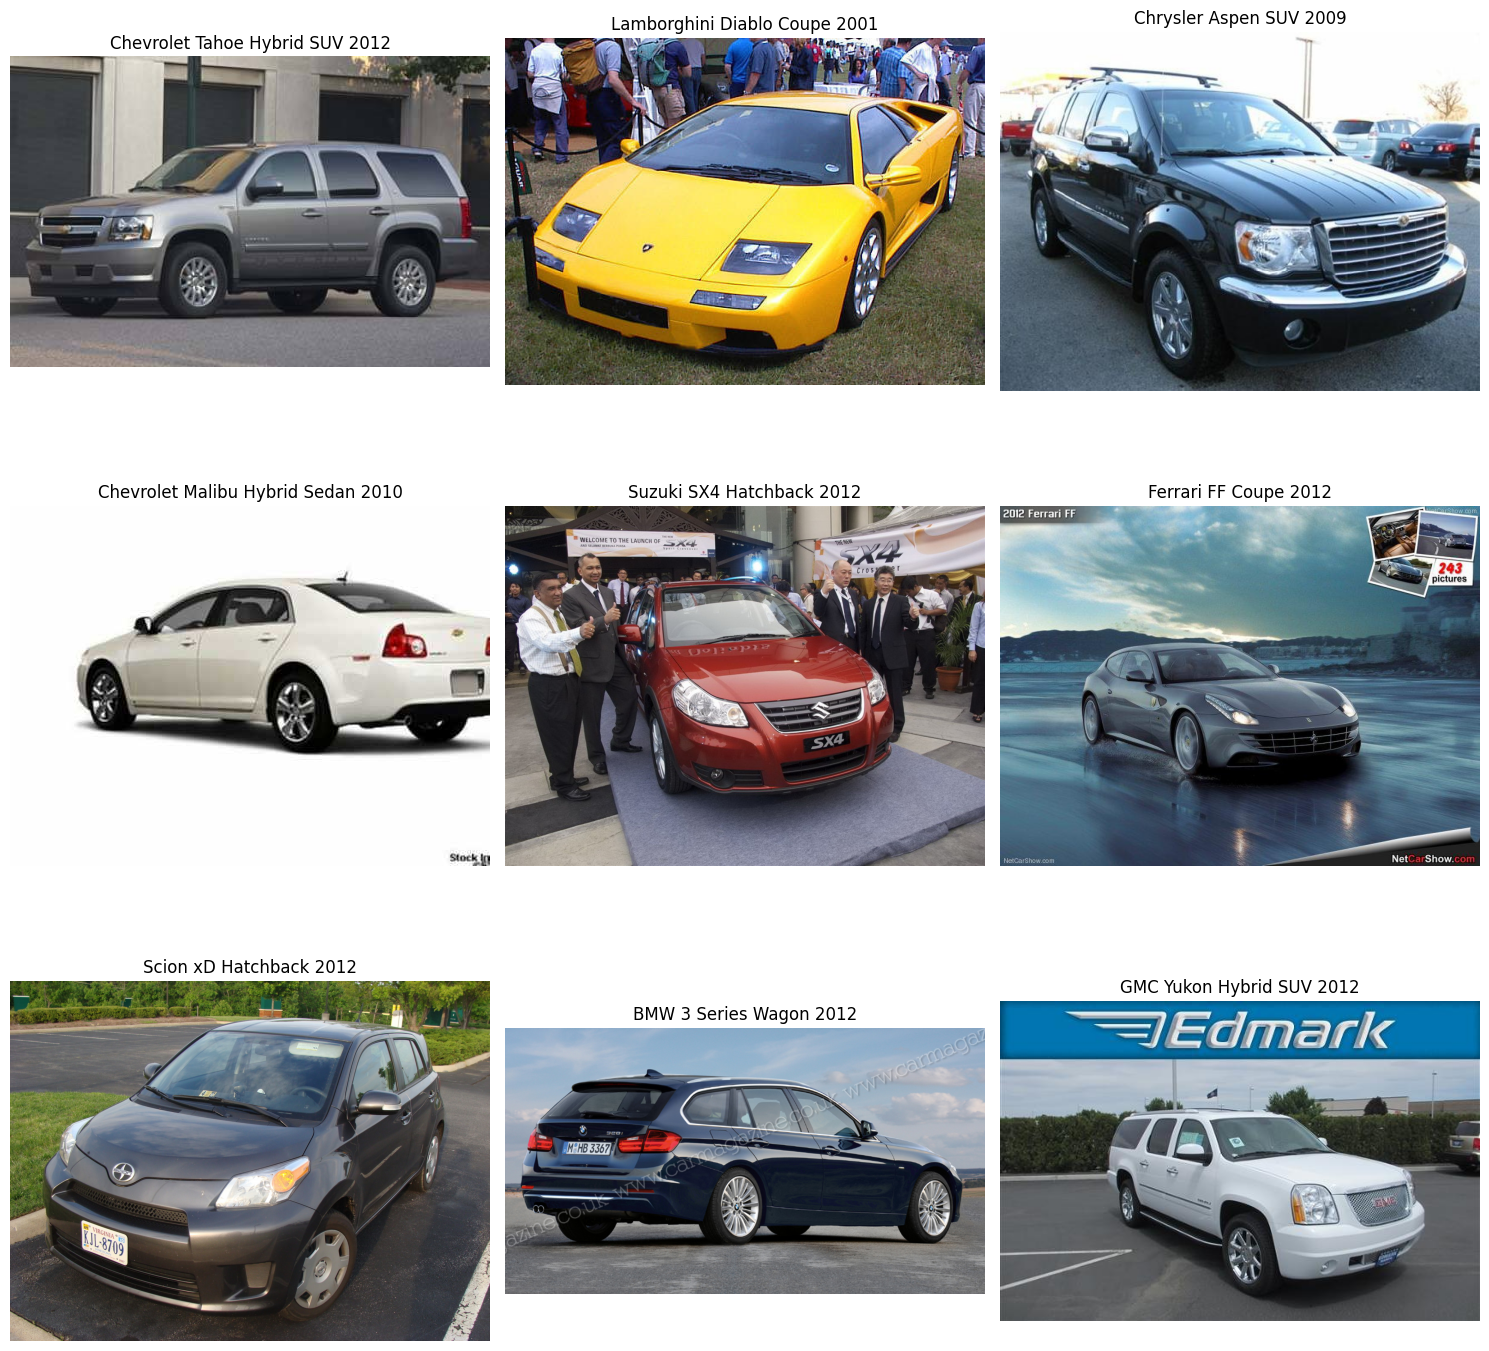

In [5]:
import os, random, cv2
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

DEVKIT_DIR = "./cars/meta"
TRAIN_DIR  = "./cars_train/cars_train"

mat = sio.loadmat(os.path.join(DEVKIT_DIR, "cars_train_annos.mat"))

ann = mat["annotations"].squeeze()           
fnames = [a["fname"].squeeze().item() for a in ann]
classes = [int(np.squeeze(a["class"])) for a in ann] 

fname_to_class = {f: c-1 for f, c in zip(fnames, classes)}

cars_meta = sio.loadmat(os.path.join(DEVKIT_DIR, "cars_meta.mat"))
id_to_car = {idx: name[0] for idx, name in enumerate(cars_meta["class_names"].squeeze())} 


num_imgs = 9
cols = 3
rows = num_imgs // cols

fig, ax = plt.subplots(rows, cols, figsize=(15, 15))

indices = random.sample(range(len(fname_to_class)), num_imgs)
items = list(fname_to_class.items())

for idx, im_idx in enumerate(indices):
    filename, cl_id = items[im_idx]
    img_path = os.path.join(TRAIN_DIR, filename)    
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Не найден файл: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax[idx // cols][idx % cols].imshow(img)
    ax[idx // cols][idx % cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx // cols][idx % cols].axis('off')

plt.tight_layout()
plt.show()


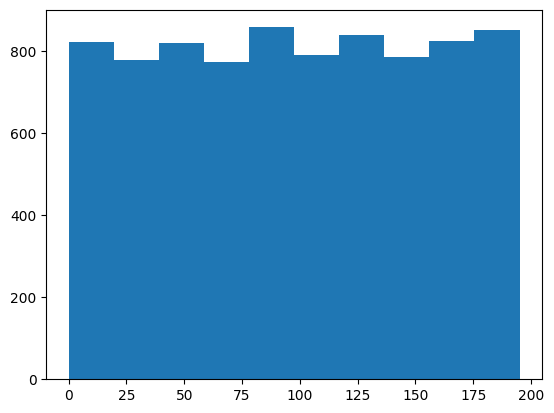

In [6]:
plt.hist(fname_to_class.values())
plt.show()

In [7]:
import os, cv2, random
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "g:\ml\2sem\NN_VK\venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "g:\ml\2sem\NN_VK\venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "g:\ml\2sem\NN_VK\venv\Lib\site-packages\ipykernel\kernelapp.py", line 758, in start
    self.io_loop.start()
  File "g:\ml\2sem\NN_VK\venv\Lib\site-packages\tornado

In [8]:
CARS_DIR  = Path("./cars")
TRAIN_DIR = CARS_DIR/"data"/"cars_train"
TEST_DIR  = CARS_DIR/"data"/"cars_test"

In [9]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomResizedCrop(224, scale=(0.6, 1.0), ratio=(0.75, 1.33)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    torchvision.transforms.RandomApply([torchvision.transforms.GaussianBlur(kernel_size=3)], p=0.2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
])

In [10]:
import scipy.io as sio
from collections import defaultdict

In [15]:
ADD_PATH = "./cars_train/cars_train"

In [16]:
class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms, root):
        self.cars = cars_items       
        self.transforms = transforms
        self.root = root                  
    def __len__(self): return len(self.cars)
    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        full = os.path.join(self.root, filename)
        img = cv2.imread(full)
        if img is None:
            raise FileNotFoundError(f"cv2.imread returned None for: {full}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transforms:
            img = self.transforms(img)
        return {"image": img, "label": int(cl_id)}
    
    
items = list(fname_to_class.items())
random.shuffle(items)
split = int(len(items) * 0.8)
train_items = items[:split]
val_items   = items[split:]


use_cuda = torch.cuda.is_available()

train_dataset = CropClassifDataset(train_items, train_transforms, ADD_PATH)
val_dataset   = CropClassifDataset(val_items,   val_transforms,   ADD_PATH)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,
                          num_workers=0, pin_memory=False, drop_last=True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,
                          num_workers=0, pin_memory=False)
len(train_dataset), len(val_dataset)

(6515, 1629)

In [17]:
import torch, torchvision
from torch import nn
import lightning.pytorch as pl
from pytorch_metric_learning import losses, miners

class Embedder(pl.LightningModule):
    def __init__(self, emb_dim=512, lr=3e-4, margin=0.2):
        super().__init__()
        # Бэкбон ≠ ResNet50: EfficientNet-B0
        backbone = torchvision.models.efficientnet_b0(weights='DEFAULT')
        in_features = backbone.classifier[1].in_features
        backbone.classifier = nn.Identity()
        self.backbone = backbone

        self.head = nn.Sequential(
            nn.Linear(in_features, emb_dim, bias=True),
            nn.BatchNorm1d(emb_dim)
        )

        self.loss_fn = losses.TripletMarginLoss(margin=margin)
        self.miner   = miners.BatchHardMiner()
        self.lr = lr

    def forward(self, x):
        feats = self.backbone(x)
        emb = self.head(feats)
        emb = nn.functional.normalize(emb)
        return emb

    def training_step(self, batch, _):
        x, y = batch["image"], batch["label"].long()
        e = self(x)
        triplets = self.miner(e, y)
        loss = self.loss_fn(e, y, triplets)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, _):
        x, y = batch["image"], batch["label"].long()
        e = self(x)
        triplets = self.miner(e, y)
        loss = self.loss_fn(e, y, triplets)
        self.log("val_loss", loss, prog_bar=True)
        return {"emb": e.detach(), "y": y.detach()}

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)

model = Embedder(emb_dim=512, lr=3e-4, margin=0.2)
model


Embedder(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_act

In [19]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor

ckpt  = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
lrmon = LearningRateMonitor(logging_interval="step")

trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[ckpt, early, lrmon],
    log_every_n_steps=20
)

trainer.fit(model, train_loader, valid_loader)
best_path = ckpt.best_model_path or None
print("Best ckpt:", best_path)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params | Mode
------------------------------------------------------
0 | backbone | EfficientNet      | 4.0 M  | eval
1 | head     | Sequential        | 656 K  | eval
2 | loss_fn  | TripletMarginLoss | 0      | eval
3 | miner    | BatchHardMiner    | 0      | eval
------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.658    Total estimated model params size (MB)
0         Modules in train mode
343       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Numpy is not available

In [ ]:
import torch, numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_path = r"c:\Users\aslan\Desktop\TechnoPark\NeuroNetworks\HW7\lightning_logs\version_5\checkpoints\epoch=12-step=1313.ckpt"

model = Embedder.load_from_checkpoint(best_path)
model.eval().to(device)

@torch.no_grad()
def get_embeddings(dloader):
    E, Y = [], []
    for b in dloader:
        x = b["image"].to(device)
        y = b["label"].cpu().numpy()
        e = model(x).cpu().numpy().astype("float32")
        E.append(e); Y.append(y)
    return np.vstack(E), np.concatenate(Y)

gallery_emb, gallery_y = get_embeddings(train_loader)
query_emb, query_y = get_embeddings(valid_loader)
gallery_emb.shape, query_emb.shape


((6464, 512), (1629, 512))

In [ ]:
import faiss
index = faiss.IndexFlatL2(gallery_emb.shape[1])
index.add(gallery_emb)
K = 10
D, I = index.search(query_emb, K) 

def precision_at_k(I, qy, gy, k=1):
    hits = (gy[I[:, :k]] == qy[:, None])
    return hits.mean() if k>1 else hits.any(axis=1).mean()

def recall_at_k(I, qy, gy, k=1):
    return (gy[I[:, :k]] == qy[:, None]).any(axis=1).mean()

def _ap_for_query(r):
    if not np.any(r): return 0.0
    tp, ps = 0, []
    for i, rel in enumerate(r, 1):
        if rel: tp += 1; ps.append(tp/i)
    return float(np.mean(ps))

def mean_average_precision(I, qy, gy, k=10):
    rel = (gy[I[:, :k]] == qy[:, None])
    return float(np.mean([_ap_for_query(r) for r in rel]))

for topk in [1,2,4,8,10]:
    print(f"Precision@{topk}: {precision_at_k(I, query_y, gallery_y, topk):.4f} | "
          f"Recall@{topk}: {recall_at_k(I, query_y, gallery_y, topk):.4f}")
print("mAP@10:", mean_average_precision(I, query_y, gallery_y, k=10))


Precision@1: 0.5095 | Recall@1: 0.5095
Precision@2: 0.4856 | Recall@2: 0.6360
Precision@4: 0.4463 | Recall@4: 0.7311
Precision@8: 0.3944 | Recall@8: 0.8072
Precision@10: 0.3784 | Recall@10: 0.8336
mAP@10: 0.5490902944914864


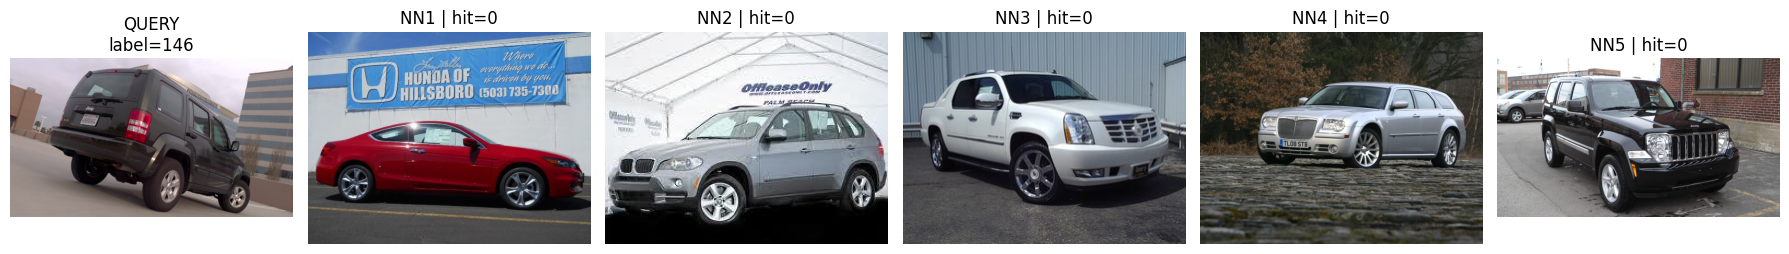

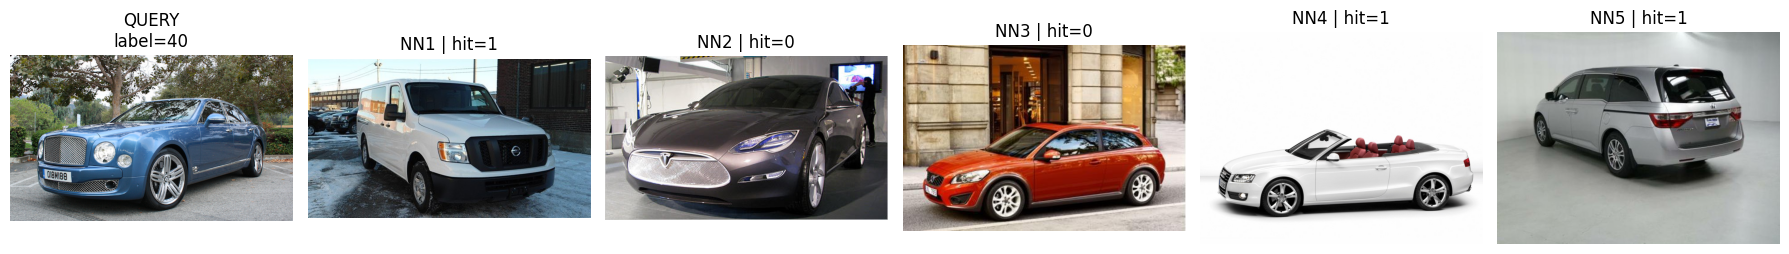

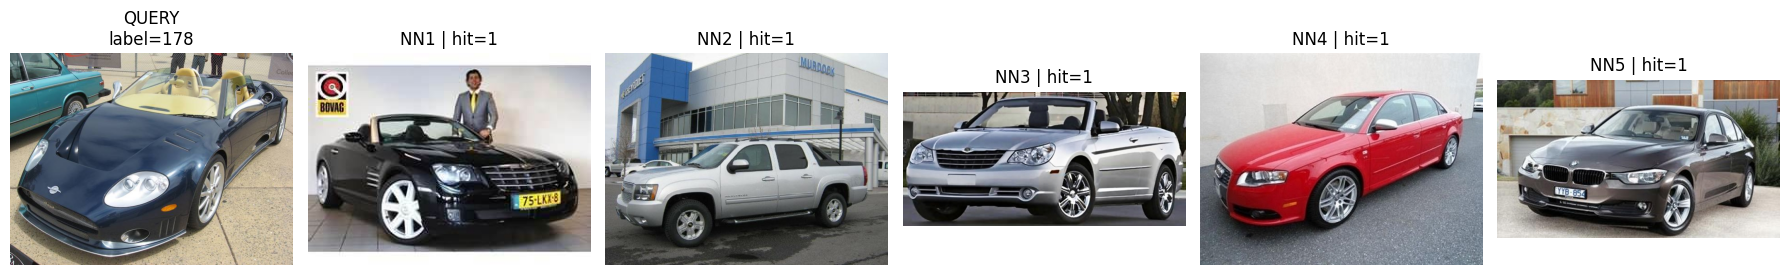

In [ ]:
train_names = [name for name,_ in train_loader.dataset.cars]
val_names   = [name for name,_ in valid_loader.dataset.cars]
ADD_PATH = "./cars/data/cars_train"

def show_retrieval(q_idx, topk=5):
    q_name = val_names[q_idx]
    q_path = os.path.join(ADD_PATH, q_name)
    nn_idx = I[q_idx, :topk]
    nn_paths = [os.path.join(ADD_PATH, train_names[j]) for j in nn_idx]

    plt.figure(figsize=(3*(topk+1), 4))
    # запрос
    plt.subplot(1, topk+1, 1)
    plt.imshow(Image.open(q_path).convert("RGB"))
    plt.title(f"QUERY\nlabel={int(query_y[q_idx])}")
    plt.axis("off")
    # соседи
    for i, (p, j) in enumerate(zip(nn_paths, nn_idx), start=2):
        plt.subplot(1, topk+1, i)
        plt.imshow(Image.open(p).convert("RGB"))
        hit = int(gallery_y[j] == query_y[q_idx])
        plt.title(f"NN{i-1} | hit={hit}")
        plt.axis("off")
    plt.tight_layout(); plt.show()

for q in [0, 5, 10]:  # примеры
    show_retrieval(q, topk=5)


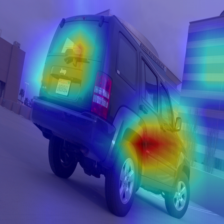

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision.transforms as T

val_tfms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(), torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
prep_for_show = T.Compose([T.ToPILImage(), T.Resize((224,224)), T.ToTensor()])

def load_tensor_train(fname):
    p = os.path.join(ADD_PATH, fname)
    img = cv2.imread(p); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x = val_tfms(img).unsqueeze(0).to(device)
    rgb = prep_for_show(img).permute(1,2,0).cpu().numpy()
    return x, rgb

q_filename, q_label = valid_loader.dataset.cars[0]
inp_x, inp_rgb = load_tensor_train(q_filename)
ref_idx = int(np.where(gallery_y == int(q_label))[0][0])
ref_filename, _ = train_loader.dataset.cars[ref_idx]
ref_x, _ = load_tensor_train(ref_filename)

with torch.no_grad():
    ref_emb = model(ref_x).detach()

class SimilarityTarget:
    def __init__(self, ref_feat): self.ref_feat = ref_feat
    def __call__(self, out): return torch.nn.functional.cosine_similarity(out, self.ref_feat, dim=1)

target_layers = [model.backbone.features[-1]]

class BackboneWithHead(nn.Module):
    def __init__(self, backbone, head): super().__init__(); self.backbone=backbone; self.head=head
    def forward(self, x):
        feats = self.backbone(x); emb = self.head(feats)
        return nn.functional.normalize(emb)

cam_model = BackboneWithHead(model.backbone, model.head).eval().to(device)
targets = [SimilarityTarget(ref_emb)]

with GradCAM(model=cam_model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=inp_x, targets=targets)[0]

cam_img = show_cam_on_image(inp_rgb, grayscale_cam, use_rgb=True)
from PIL import Image
Image.fromarray(cam_img)


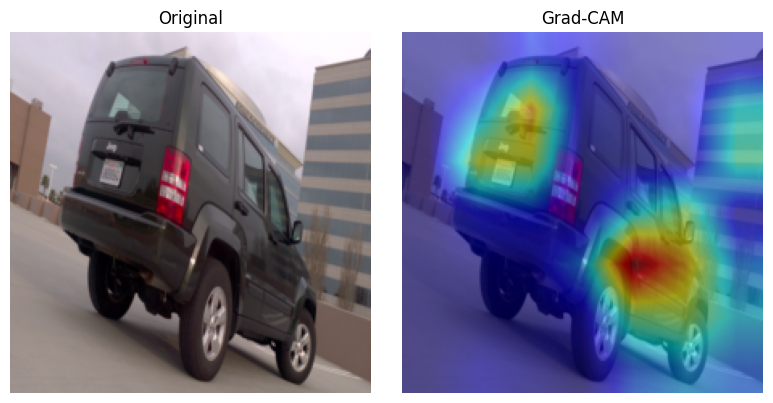

In [ ]:
def show_cam_pair(rgb_img, cam_overlay):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(rgb_img); plt.title("Original"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(cam_overlay); plt.title("Grad-CAM"); plt.axis("off")
    plt.tight_layout(); plt.show()

show_cam_pair(inp_rgb, cam_img)

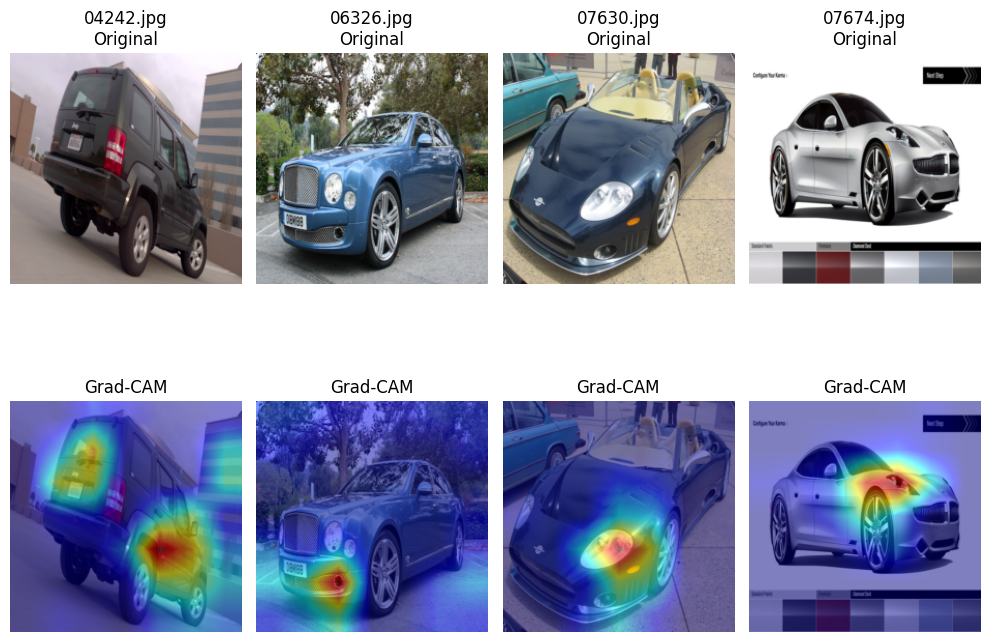

In [ ]:
def make_cam_for_idx(q_idx):
    q_filename, q_label = valid_loader.dataset.cars[q_idx]
    inp_x, inp_rgb = load_tensor_train(q_filename)

    ref_idx = int(np.where(gallery_y == int(q_label))[0][0])
    ref_filename, _ = train_loader.dataset.cars[ref_idx]
    ref_x, _ = load_tensor_train(ref_filename)
    with torch.no_grad(): ref_emb = model(ref_x).detach()

    targets = [SimilarityTarget(ref_emb)]
    with GradCAM(model=cam_model, target_layers=target_layers) as cam:
        gray = cam(input_tensor=inp_x, targets=targets)[0]
    cam_overlay = show_cam_on_image(inp_rgb, gray, use_rgb=True)
    return inp_rgb, cam_overlay, q_filename

idxs = [0, 5, 10, 30]
plt.figure(figsize=(10,8))
for i, q in enumerate(idxs, 1):
    rgb, overlay, name = make_cam_for_idx(q)
    plt.subplot(2, len(idxs), i);     plt.imshow(rgb);     plt.title(f"{name}\nOriginal"); plt.axis("off")
    plt.subplot(2, len(idxs), i+len(idxs)); plt.imshow(overlay); plt.title("Grad-CAM"); plt.axis("off")
plt.tight_layout(); plt.show()


Ошибочных примеров: 799


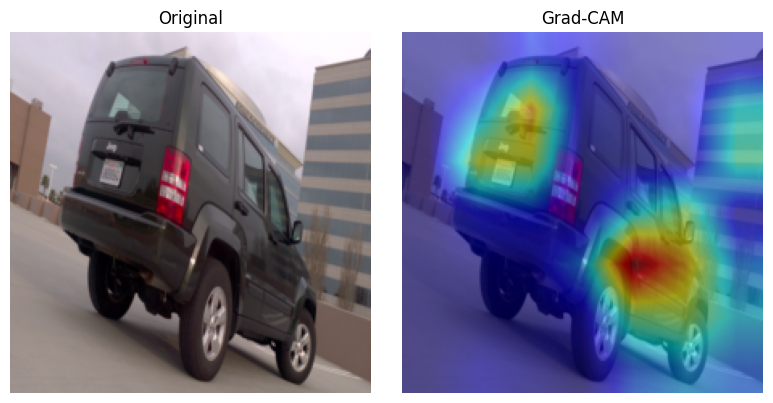

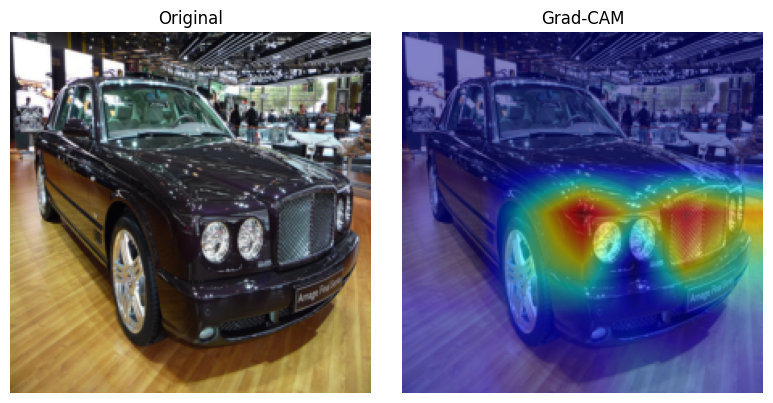

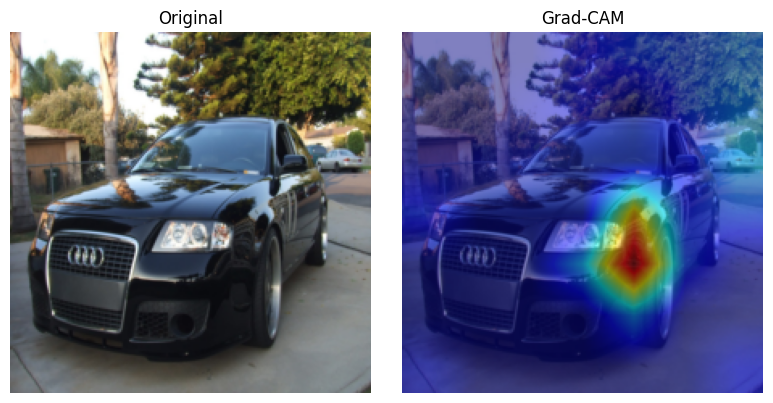

In [ ]:
wrong = np.where(gallery_y[I[:,0]] != query_y)[0]
print("Ошибочных примеров:", len(wrong))

for q in wrong[:3]:
    rgb, overlay, name = make_cam_for_idx(q)
    show_cam_pair(rgb, overlay)


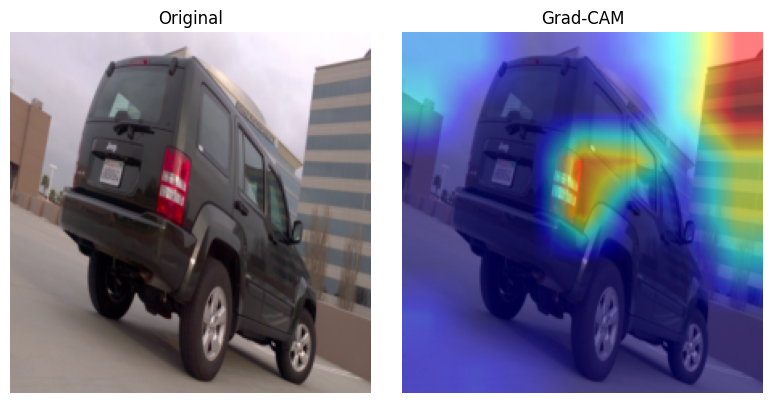

In [ ]:
q = int(wrong[0])
bad_nn = I[q,0]
bad_fname, _ = train_loader.dataset.cars[bad_nn]
bad_x, _ = load_tensor_train(bad_fname)
with torch.no_grad(): bad_emb = model(bad_x).detach()

targets_bad = [SimilarityTarget(bad_emb)]
with GradCAM(model=cam_model, target_layers=target_layers) as cam:
    gray_bad = cam(input_tensor=load_tensor_train(valid_loader.dataset.cars[q][0])[0], targets=targets_bad)[0]

cam_bad = show_cam_on_image(
    load_tensor_train(valid_loader.dataset.cars[q][0])[1], gray_bad, use_rgb=True
)

show_cam_pair(load_tensor_train(valid_loader.dataset.cars[q][0])[1], cam_bad)
